In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from eumap.misc import find_files, ttprint, nan_percentile, GoogleSheet
from eumap.raster import read_rasters, save_rasters
import warnings
import multiprocess as mp
import time
from scipy.special import expit, logit
import warnings
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
import joblib
import pickle
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from cubist import Cubist
from sklearn.base import BaseEstimator, TransformerMixin
from pathlib import Path
import os
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import cross_val_predict
import math
from quantile_forest import RandomForestQuantileRegressor
import shap
# df = pd.read_csv(f'/mnt/primus/xuemeng_tmp_harbour/soc/data/002_data_whole.csv',low_memory=False)
output_folder = '/mnt/primus/xuemeng_tmp_harbour/soc/results'

# a = find_files('/mnt/primus/xuemeng_tmp_harbour/soc/results/', 'model_rf.*.ccc.joblib')
# a = [str(i) for i in a]

prop = 'oc'
file_rf = '/mnt/primus/xuemeng_tmp_harbour/soc/results/CEC/model_rf.CEC_log1p.ccc.joblib'

results = []
cv = GroupKFold(n_splits=5)  
spatial_cv_column = 'tile_id'

test = pd.read_csv(f'{output_folder}/{prop}/benchmark_test.pnts_{prop}.csv',low_memory=False)
train = pd.read_csv(f'{output_folder}/{prop}/benchmark_train.pnts_{prop}.csv',low_memory=False)

covs_a = pd.read_csv(f'{output_folder}/{prop}/benchmark_selected.covs_{prop}.txt').values.tolist()
covs = [item for sublist in covs_a for item in sublist]
    
train = train.dropna(subset=covs,how='any')
test = test.dropna(subset=covs,how='any')


# params = rf.get_params()
# # params['n_jobs'] = 90
# qrf = RandomForestQuantileRegressor(**params)

### SHAP on RF predictions

In [2]:
# get SHAP values
rf = joblib.load(file_rf)
rf.n_jobs = 90
rf.fit(train[covs],train[prop])
y_pred_test = rf.predict(test[covs]) 

ttprint('start SHAP calculating')
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(test[covs])
ttprint('finish SHAP calculating')

with open(f'{output_folder}/SHAP/shap.values_v0625.csv', 'wb') as f:
    pickle.dump(shap_values, f)

[09:49:06] start SHAP calculating
[10:41:11] finish SHAP calculating


In [5]:
# get feature improtance, and store them in a dataframe in a sorted way
feature_importances = rf.feature_importances_
features = train[covs].columns
feature_importance_df = pd.DataFrame({'feature': features, 'importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Select top 10 important features
top_features = feature_importance_df.head(10)['feature'].tolist()


In [8]:
feature_importance_df.head(10)

,feature,importance
88,pet.penman.max_chelsa_m_1km_s_19810101_2010123...,0.074539
97,rsds.mean_chelsa_m_1km_s_19810101_20101231_eu_...,0.050249
40,lithology_EGDI_peat,0.039571
114,vpd.mean_chelsa_m_1km_s_19810101_20101231_eu_e...,0.037035
113,vpd.max_chelsa_m_1km_s_19810101_20101231_eu_ep...,0.027764
38,hzn_dep,0.026396
43,lst_mod11a2.daytime_p50_1km_s_{year}0101_{year...,0.024955
72,ndti_glad.landast.ard2.seasconv.m.yearly_p25_3...,0.022488
98,rsds.min_chelsa_m_1km_s_19810101_20101231_eu_e...,0.017541
0,accum.ndvi_glad.landsat.seasconv.m.yearly_p50_...,0.015073


Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


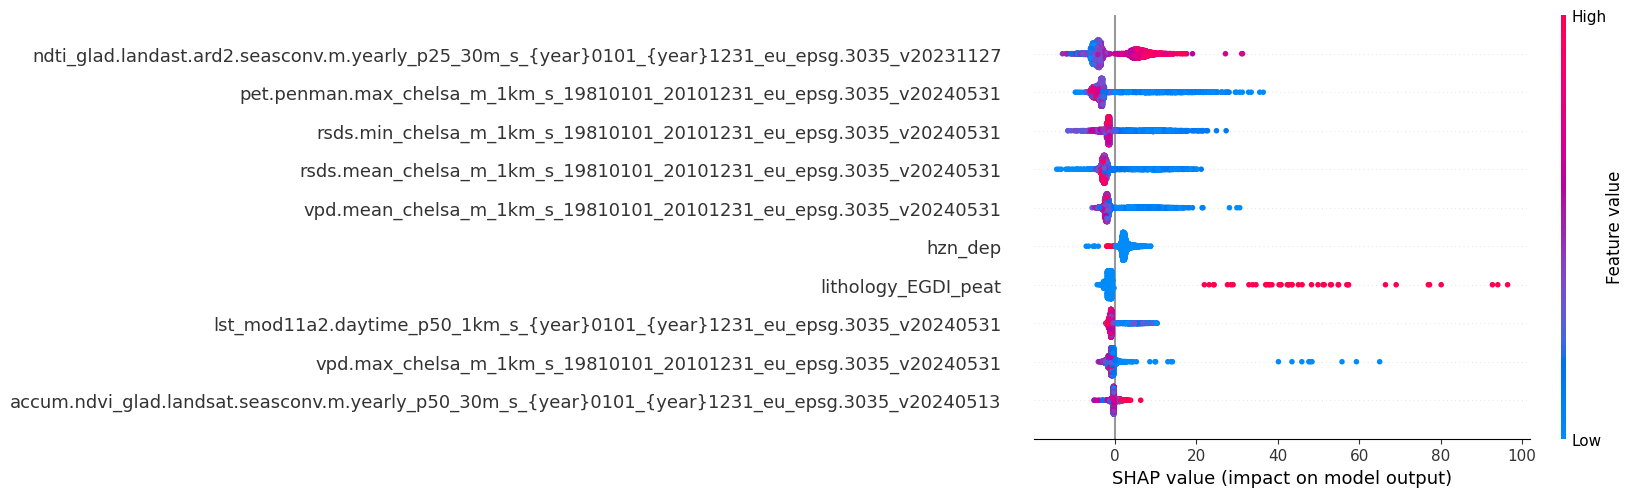

In [11]:
# Select features of interest
covs_interest = top_features
ind_interest = [test[covs].columns.get_loc(feat) for feat in covs_interest]

# Generate the SHAP summary plot for selected features
shap.summary_plot(shap_values[:, ind_interest], test[covs_interest])

In [14]:
len(covs)

133

TypeError: predict() got an unexpected keyword argument 'output_margin'

### quantile random forest - metrics
- cv
- individual test

In [1]:


quantiles = [0.05, 0.95]
ttprint(f'quantile, cv, {prop}')
predictions = quantile_cross_val_predict(qrf, train[covs], train[prop], cv, quantiles, groups = train[spatial_cv_column])
picp_cv = calc_picp(np.array(predictions[quantiles[0]]), np.array(predictions[quantiles[1]]), train[prop])
    
qcp_cv_lower = calc_qcp(np.array(predictions[quantiles[0]]), train[prop], quantiles[0])
qcp_cv_upper = calc_qcp(np.array(predictions[quantiles[1]]), train[prop], quantiles[1])
    
piw_cv = np.mean(np.array(predictions[quantiles[1]])-np.array(predictions[quantiles[0]]))

    
ttprint(f'quantile, individual test, {prop}')
qrf.fit(train[covs], train[prop])
y_pred_test = qrf.predict(test[covs], quantiles=quantiles)
picp_test = calc_picp(y_pred_test[:,0], y_pred_test[:,1], test[prop])
    
qcp_test_lower = calc_qcp(y_pred_test[:,0], test[prop], quantiles[0])
qcp_test_upper = calc_qcp(y_pred_test[:,1], test[prop], quantiles[1])
    
piw_test = np.mean(y_pred_test[:,1]-y_pred_test[:,0])
    
results.append({
    'property': 'qrf',
    'picp': picp_test,
    'piw': piw_test,
    'qcp05': qcp_test_lower,
    'qcp95': qcp_test_upper
})
    

### explain the model with SHAP values

In [ ]:
# https://shap.readthedocs.io/en/latest/

In [4]:
import numpy as np
quantiles = [0.005, 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.495, 0.5 , 0.505, 0.55,
             0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 0.995]

qrf.fit(train[covs], train[prop])
y_pred_test = qrf.predict(test[covs], quantiles=quantiles)

/home/opengeohub/.local/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(


In [5]:

qcp = []
for ii in range(len(quantiles)):
    qcp.append(calc_qcp(y_pred_test[:,ii], test[prop], quantiles[ii]))

pi = []
picp = []
piw = []
for ii in range(11):
    jj = len(quantiles)-1-ii
    pi.append(round(1-quantiles[ii]*2,2))
    picp.append(calc_picp(y_pred_test[:,ii], y_pred_test[:,jj], test[prop]))
    piw.append(np.mean(y_pred_test[:,jj]-y_pred_test[:,ii]))


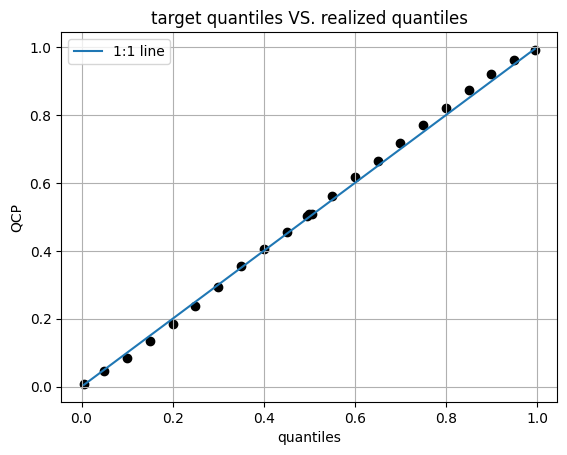

In [6]:
fig, ax = plt.subplots()
ax.plot(quantiles, quantiles, label='1:1 line')
ax.scatter(quantiles, qcp, color='black')
ax.set_xlabel('quantiles')
ax.set_ylabel('QCP')
ax.set_title('target quantiles VS. realized quantiles')
ax.grid(True)
plt.legend()
plt.show()

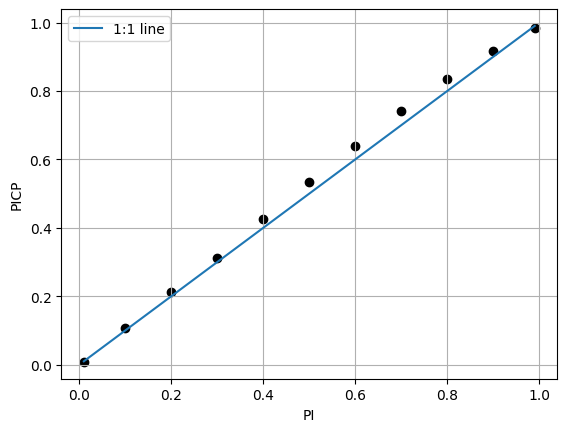

In [7]:
fig, ax = plt.subplots()
ax.plot(pi, pi, label='1:1 line')
ax.scatter(pi, picp, color='black')
ax.set_xlabel('PI')
ax.set_ylabel('PICP')
ax.grid(True)
plt.legend()
plt.show()

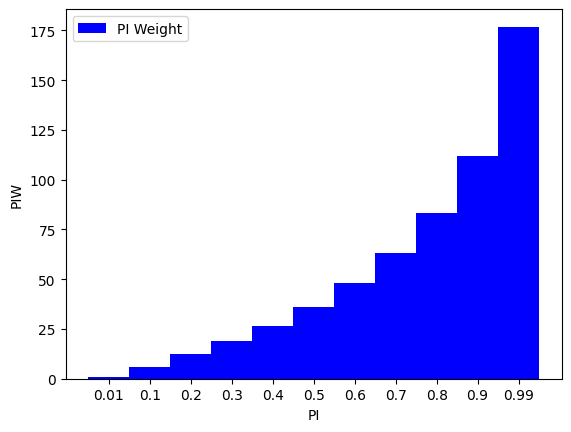

In [8]:
x_positions = list(range(len(piw), 0, -1))

fig, ax = plt.subplots()
ax.bar(x_positions, piw, width=1, color='blue', label='PI Weight')
ax.set_xticks(x_positions)  # Set x-ticks at the positions listed in `pi`
ax.set_xticklabels([f'{p}' for p in pi])
ax.set_xlabel('PI')
ax.set_ylabel('PIW')
# ax.grid(True)
plt.legend()
plt.show()

### validate on validation set time series

In [9]:
test['oc_quantile.95'] = y_pred_test[:,-2]
test['oc_quantile.05'] = y_pred_test[:,1]

In [11]:
data = test[test['hzn_dep'] == 10]
columns_of_interest = ['id', 'time', 'oc', 'oc_quantile.95', 'oc_quantile.05']
data = data[columns_of_interest]

data

,id,time,oc,oc_quantile.95,oc_quantile.05
1,56922206,2009.0,6.5,28.420,6.4000
3,56882134,2009.0,14.8,45.725,8.3000
4,56722160,2009.0,15.6,30.640,8.2450
5,56302122,2009.0,7.9,25.230,5.2000
6,55682118,2009.0,4.7,22.675,5.2000
...,...,...,...,...,...
4540,34923790,2018.0,28.9,102.945,9.5335
4541,34983770,2018.0,19.1,130.650,9.8850
4542,34443626,2018.0,34.6,148.928,23.8500
4543,35483702,2018.0,44.1,301.185,22.8750


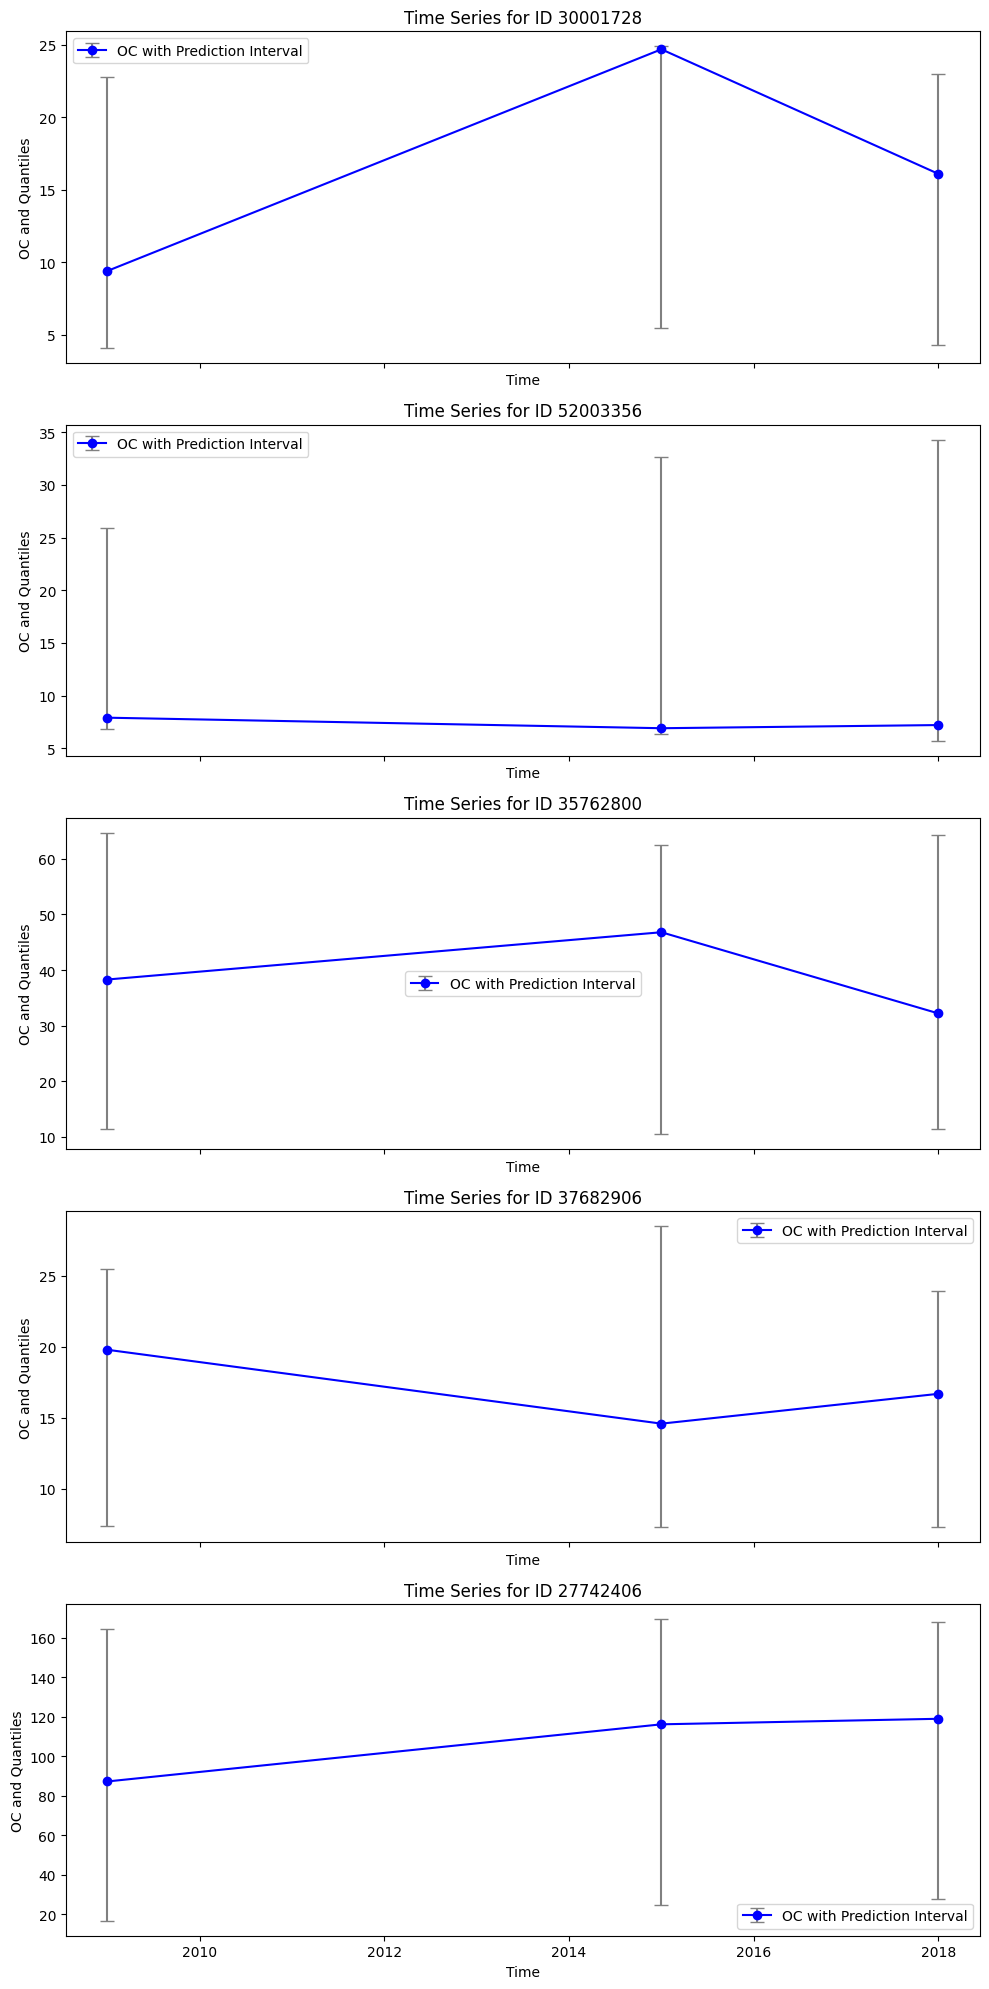

In [13]:
sample_ids = np.random.choice(data['id'].unique(), size=5, replace=False)
fig, axes = plt.subplots(nrows=len(sample_ids), ncols=1, figsize=(10, 20), sharex=True)

for i, sample_id in enumerate(sample_ids):
    sample_data = data[data['id'] == sample_id].sort_values('time')
    
    # Using error bars to represent quantiles instead of fill_between
    axes[i].errorbar(sample_data['time'], sample_data['oc'], 
                     yerr=[sample_data['oc'] - sample_data['oc_quantile.05'], sample_data['oc_quantile.95'] - sample_data['oc']], 
                     fmt='o', linestyle='-', color='blue', ecolor='gray', capsize=5, label='OC with Prediction Interval')
    
    axes[i].set_title(f'Time Series for ID {sample_id}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('OC and Quantiles')
    axes[i].legend()

plt.tight_layout()
plt.show()


In [20]:
def check_non_overlapping_intervals(data):
    data = data.sort_values('time')
    for i in range(len(data) - 1):
        if not (data.iloc[i]['oc_quantile.95'] < data.iloc[i + 1]['oc_quantile.05'] or
                data.iloc[i]['oc_quantile.05'] > data.iloc[i + 1]['oc_quantile.95']):
            return False
    return True

non_overlapping_ids = []
for id, group in test[test['hzn_dep'] == 10].groupby('id'):
    if len(group['time'].unique()) > 1 and check_non_overlapping_intervals(group):
        non_overlapping_ids.append(id)


In [21]:
import matplotlib.pyplot as plt

for sample_id in non_overlapping_ids:
    sample_data = test[test['id'] == sample_id].sort_values('time')
    plt.figure(figsize=(10, 4))
    plt.fill_between(sample_data['time'], sample_data['oc_quantile.05'], sample_data['oc_quantile.95'], color='gray', alpha=0.5)
    plt.plot(sample_data['time'], sample_data['oc'], marker='o', linestyle='-', color='blue')
    plt.title(f'Time Series for ID {sample_id}')
    plt.xlabel('Time')
    plt.ylabel('OC and Quantiles')
    plt.show()

In [24]:
non_overlapping_ids

[]

In [18]:
test.loc[test['id']==48544672]

,id,lat,lon,time,ref,nuts0,oc,ph_h2o,ph_cacl2,bulk_density,...,lithology_EGDI_trachyte,lithology_EGDI_trachytoid,lithology_EGDI_tuffBrecciaAgglomerateOrPyroclasticBreccia,lithology_EGDI_ultramaficIgneousRock,lithology_EGDI_wacke,lithology_EGDI_Unpopulated,hzn_dep,oc_log1p,oc_quantile.95,oc_quantile.05
4481,48544672,64.769362,21.186397,2018.0,LUCAS,SE,499.3,3.8,3.1,NaN,...,0,0,0,0,1,0,10.0,6.215208,496.325,9.99


In [30]:
import pandas as pd

prop_list = ['oc', 'ph_h2o', 'ph_cacl2', 'bulk_density', 'caco3', 'CEC', 'EC', 'P', 'K', 'N']
higher_better = ['R2_val', 'CCC_val', 'R2_cv', 'CCC_cv']
lower_better = ['RMSE_val', 'RMSE_cv'] #, 'cv_time (s)', 'test_time (s)'
best = []

for prop in prop_list:
    df = pd.read_csv(f'/mnt/primus/xuemeng_tmp_harbour/soc/results/{prop}/benchmark_metrics_{prop}.csv')
    df['property'] = prop

    # Ranking the metrics appropriately
    for col in higher_better:
        df[col + '_rank'] = df[col].rank(method='min', ascending=False)
        
    for col in lower_better:
        df[col + '_rank'] = df[col].rank(method='min', ascending=True)
        
    # Sum only the necessary rank columns
    rank_columns = [col + '_rank' for col in higher_better + lower_better]
    df['total_rank'] = df[rank_columns].sum(axis=1)
    df_sorted = df.sort_values(by='total_rank')
    best_model = df_sorted.iloc[0]

    # Drop rank columns from the best model row
    best_model = best_model.drop(rank_columns + ['total_rank'])

    best.append(best_model)

# Convert best list to DataFrame to view all best models from each property
best_df = pd.DataFrame(best)

# Reordering columns to put 'property' first
column_order = ['property'] + [col for col in best_df.columns if col != 'property']
best_df = best_df[column_order]

print(best_df)



       property         title    R2_val  RMSE_val   CCC_val     R2_cv  \
0            oc            rf  0.550675  0.611548  0.705930  0.624623   
0        ph_h2o            rf  0.762732  0.660015  0.858765  0.674683   
0      ph_cacl2            rf  0.765558  0.687311  0.860912  0.655177   
4  bulk_density  lgb_weighted  0.292882  0.414352  0.435651  0.445969   
3         caco3   rf_weighted  0.667276  1.271670  0.786871  0.601751   
2           CEC           lgb  0.415466  0.540335  0.569839  0.422562   
3            EC   rf_weighted  0.369354  0.590715  0.509706  0.507062   
3             P   rf_weighted  0.296192  0.957347  0.457729  0.346011   
3             K   rf_weighted  0.419998  0.683437  0.572280  0.398401   
0             N            rf  0.616684  0.406434  0.754714  0.757725   

    RMSE_cv    CCC_cv  cv_time (s)  test_time (s)  Unnamed: 0  
0  0.676012  0.763311   614.944233     736.984381         NaN  
0  0.719266  0.796075   290.555274     328.525917         NaN  
0  0

In [32]:
best_df.drop(columns='Unnamed: 0')
best_df

,property,title,R2_val,RMSE_val,CCC_val,R2_cv,RMSE_cv,CCC_cv,cv_time (s),test_time (s),Unnamed: 0
0,oc,rf,0.550675,0.611548,0.705930,0.624623,0.676012,0.763311,614.944233,736.984381,NaN
0,ph_h2o,rf,0.762732,0.660015,0.858765,0.674683,0.719266,0.796075,290.555274,328.525917,NaN
0,ph_cacl2,rf,0.765558,0.687311,0.860912,0.655177,0.776174,0.783522,258.228914,301.483572,0.0
4,bulk_density,lgb_weighted,0.292882,0.414352,0.435651,0.445969,0.308375,0.618167,8.882182,0.524796,4.0
3,caco3,rf_weighted,0.667276,1.271670,0.786871,0.601751,1.315935,0.734305,684.725839,678.963798,NaN
2,CEC,lgb,0.415466,0.540335,0.569839,0.422562,0.574404,0.580318,7.355814,0.666214,NaN
3,EC,rf_weighted,0.369354,0.590715,0.509706,0.507062,0.596562,0.658933,485.496367,564.575928,NaN
3,P,rf_weighted,0.296192,0.957347,0.457729,0.346011,0.896511,0.496441,539.523615,666.693592,NaN
3,K,rf_weighted,0.419998,0.683437,0.572280,0.398401,0.692988,0.550719,311.691685,362.179350,NaN
0,N,rf,0.616684,0.406434,0.754714,0.757725,0.424957,0.857447,307.250937,367.733524,NaN


In [ ]:


# Rank the models in each metric
